We will test the implementation of long-range interactions by trying to reproduce the results of [arXiv:1204.4531](https://arxiv.org/abs/1204.4531).

Create monolayer graphene model in kwant.

In [1]:
import kwant
import numpy as np
import matplotlib.pyplot as plt


s0 = np.identity(2)
sz = np.diag([1, -1])


graphene = kwant.lattice.general(
    [[1, 0], [1 / 2, np.sqrt(3) / 2]], [[0, 0], [0, 1 / np.sqrt(3)]]
)
a, b = graphene.sublattices

# create bulk system
bulk_graphene = kwant.Builder(kwant.TranslationalSymmetry(*graphene.prim_vecs))
# add sublattice potential
m0 = 0
bulk_graphene[a.shape((lambda pos: True), (0, 0))] = m0 * sz
bulk_graphene[b.shape((lambda pos: True), (0, 0))] = -m0 * sz
# add hoppings between sublattices
bulk_graphene[graphene.neighbors(1)] = s0

# use kwant wraparound to sample bulk k-space
wrapped_syst_unfinalized = kwant.wraparound.wraparound(bulk_graphene)
wrapped_syst = kwant.wraparound.wraparound(bulk_graphene).finalized()


# return a hamiltonian for a given kx, ky
@np.vectorize
def hamiltonian_return(kx, ky, params={}):
    ham = wrapped_syst.hamiltonian_submatrix(params={**params, **dict(k_x=kx, k_y=ky)})
    return ham

Now we sample the non-interacting hamiltonian on a k-grid:

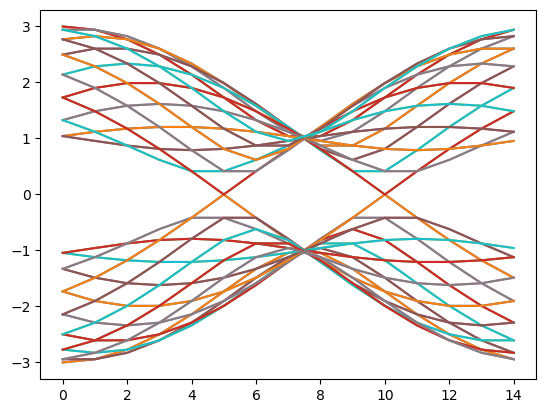

In [143]:
N_ks = 15  # number of k-points in each direction
N_k_axis = np.linspace(0, 2 * np.pi, N_ks, endpoint=False)
hamiltonians_0 = np.array(
    [[hamiltonian_return(kx, ky) for kx in N_k_axis] for ky in N_k_axis]
)

vals0, vecs0 = np.linalg.eigh(hamiltonians_0)
for i in range(len(vals0[:, 0, 0])):
    for j in range(4):
        plt.plot(vals0[i, :, j])

In [144]:
def mean_field_F(vals, vecs, E_F=0):
    N_ks = vals.shape[0]

    def mf_generator(i, j):
        vals_i = vals[i, j, :]
        vecs_i = vecs[i, j, :, :]
        n_occ = vals_i < E_F
        occ_vecs = vecs_i[:, n_occ]
        F_ij = occ_vecs @ occ_vecs.conj().T
        return F_ij

    F = np.array([[mf_generator(i, j) for i in range(N_ks)] for j in range(N_ks)])
    return F


def get_fermi_energy(vals_flat, filling):
    ne = len(vals_flat)
    ifermi = int(round(ne * filling))  # index for fermi
    if ifermi >= ne:
        ifermi = ne - 1
    sorte = np.sort(vals_flat)  # sorted eigenvalues
    if ifermi == 0:
        return sorte[0]
    fermi = (sorte[ifermi - 1] + sorte[ifermi]) / 2.0  # fermi energy
    return fermi


from scipy.signal import convolve2d


def convolution(M1, M2):
    cell_size = Vk.shape[2]
    V_output = np.array(
        [
            [
                convolve2d(M1[:, :, i, j], M2[:, :, i, j], boundary="wrap", mode="same")
                for i in range(cell_size)
            ]
            for j in range(cell_size)
        ]
    )
    V_output = np.transpose(V_output, axes=(2, 3, 0, 1))
    return V_output


def dm(mf0,mf):
    return np.mean(np.abs(mf - mf0))

def energy_per_atom(vals, E_F):
    N_filling = np.sum((vals < E_F).flatten())
    E_total = np.sum(vals[vals < E_F].flatten())
    E_p_atom = E_total / N_filling
    return E_p_atom

In [145]:
def func_onsite(site, U):
    return U * np.ones((2, 2))

def func_hop(site1, site2, V):
    rij = np.linalg.norm(site1.pos - site2.pos)
    return V * np.ones((2, 2))

lattice = graphene
syst = wrapped_syst_unfinalized

@np.vectorize
def compute_Vk(dummy_syst, kx, ky, params={}):
    V = dummy_syst.hamiltonian_submatrix(params={**params, **dict(k_x=kx, k_y=ky)})
    return V


def potential_to_hamiltonian(
    syst, lattice, func_onsite, func_hop, params, max_neighbor=2, single_k = False, k_point=None
):
    V = kwant.Builder(kwant.TranslationalSymmetry(*lattice.prim_vecs))
    V[syst.sites()] = func_onsite
    V[lattice.neighbors()] = func_hop
    wrapped_V = kwant.wraparound.wraparound(V).finalized()
    if single_k:
        return compute_Vk(dummy_syst=wrapped_V, kx=k_point[0], ky=k_point[1], params=params)
    else:
        return np.array(
            [
                [
                    compute_Vk(dummy_syst=wrapped_V, kx=kx, ky=ky, params=params)
                    for kx in N_k_axis
                ]
                for ky in N_k_axis
            ]
        )

Uk = potential_to_hamiltonian(
    syst=wrapped_syst_unfinalized,
    lattice=graphene,
    func_onsite=func_onsite,
    func_hop=func_hop,
    params=dict(U=1, V=0),
)

Vk = potential_to_hamiltonian(
    syst=wrapped_syst_unfinalized,
    lattice=graphene,
    func_onsite=func_onsite,
    func_hop=func_hop,
    params=dict(U=0, V=1),
)


U0 = potential_to_hamiltonian(
    syst=wrapped_syst_unfinalized,
    lattice=graphene,
    func_onsite=func_onsite,
    func_hop=func_hop,
    params=dict(U=1, V=0),
    single_k = True,
    k_point = [0,0]
)

V0 = potential_to_hamiltonian(
    syst=wrapped_syst_unfinalized,
    lattice=graphene,
    func_onsite=func_onsite,
    func_hop=func_hop,
    params=dict(U=0, V=1),
    single_k = True,
    k_point = [0,0]
)

In [158]:
Us = np.linspace(0, 5, 100)
Vs = np.linspace(0, 5, 100)

In [163]:
def scf_loop(U, V):
    H_int = U * Uk + V * Vk
    H0_int = U * U0 + V * V0
    mixing = 0.6
    threshold = 1e-5
    for n in range(5000):
        if n == 0:
            mf = 0.01 * (np.diag(np.random.rand(4)) - 0.5)  # starting guess
            hamiltonians = hamiltonians_0 + mf
            vals, vecs = np.linalg.eigh(hamiltonians)
            E_F = get_fermi_energy(vals.flatten(), 0.5)
        F = mean_field_F(vals, vecs, E_F=E_F)
        rho = np.diag(np.average(F, axis=(0, 1)))
        exchange_mf = convolution(F, H_int) * N_ks ** (-2)
        direct_mf = np.diag(np.einsum("i,ij->j", rho, H0_int))

        mf_new = direct_mf - exchange_mf
        hamiltonians = hamiltonians_0 + mixing * mf_new + (1 - mixing) * mf

        vals, vecs = np.linalg.eigh(hamiltonians)
        E_F = get_fermi_energy(vals.flatten(), 0.5)
        delta_m = dm(mf_new, mf)
        if delta_m < threshold:
            emax = np.max(vals[vals<=E_F])
            emin = np.min(vals[vals>E_F])
            E_p_atom = energy_per_atom(vals, E_F)
            return np.abs(emin - emax)
        mf = mf_new

In [164]:
from tqdm import tqdm
gap = []
for U in tqdm(Us):
    gap_U = []
    for V in Vs:
        gap_U.append(scf_loop(U, V))
    gap.append(gap_U)

100%|██████████| 100/100 [53:07<00:00, 31.88s/it]


In [180]:
gap = np.asarray(gap, dtype=float)

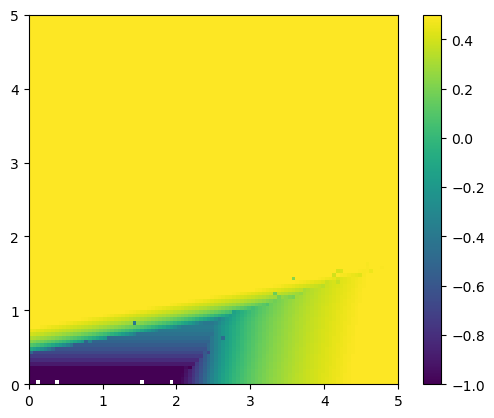

In [192]:
plt.imshow(np.log10(gap).T, origin='lower', extent=(0, 5, 0, 5), vmin=-1, vmax=0.5)
plt.colorbar()